In [1]:
from datamaker_f import VideoDataGenerator
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Function to convert byte arrays back to PIL images
def bytes_to_pil(byte_data):
    with BytesIO(byte_data) as buffer:
        return Image.open(buffer)

with open('../data/video_data_main_2.pkl', 'rb') as f:
    pickled_data = pickle.load(f)

In [3]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frame_label'][0]) for video_name, video_info in pickled_data.items()])

In [4]:
# Split the data
train_names, temp_names, train_labels, temp_labels = train_test_split(video_names, labels, test_size=0.2, random_state=42)
val_names, test_names, val_labels, test_labels = train_test_split(temp_names, temp_labels, test_size=0.5)

In [5]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}


In [6]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)

val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

In [7]:
model_test_1 = build_full_model()

In [8]:
optimizer = Adam(learning_rate=1e-4)  # Clip gradients by norm

In [9]:
# compile the model
model_test_1.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [10]:
model_test_1.summary()

Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 spatial_feature_extractor   (None, 2048)                 2358771   ['input_1[0][0]']             
 (Functional)                                             2                                       
                                                                                                  
 micro_exp_spatial_feature_  (None, 128)                  2224448   ['input_2[0][0]']    

In [11]:
# Train the model with callbacks
history = model_test_1.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping],
    batch_size=32
)

Epoch 1/60
65/65 [==============================] - 373s 6s/step - loss: 1.1089 - accuracy: 0.5034 - val_loss: 0.7817 - val_accuracy: 0.5231 - lr: 1.0000e-04
Epoch 2/60
65/65 [==============================] - 399s 6s/step - loss: 0.8628 - accuracy: 0.5202 - val_loss: 0.7809 - val_accuracy: 0.5385 - lr: 1.0000e-04
Epoch 3/60
65/65 [==============================] - 396s 6s/step - loss: 0.7986 - accuracy: 0.5717 - val_loss: 0.6666 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 4/60
65/65 [==============================] - 410s 6s/step - loss: 0.7088 - accuracy: 0.6396 - val_loss: 0.6220 - val_accuracy: 0.6923 - lr: 1.0000e-04
Epoch 5/60
65/65 [==============================] - 419s 6s/step - loss: 0.6210 - accuracy: 0.7036 - val_loss: 0.5516 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 6/60
65/65 [==============================] - 426s 7s/step - loss: 0.5295 - accuracy: 0.7796 - val_loss: 0.5627 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 7/60
65/65 [==============================] - 

In [12]:
# Evaluate the model
test_loss, test_accuracy = model_test_1.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

9/9 [==============================] - 7s 791ms/step - loss: 0.4745 - accuracy: 0.8269
Test Loss: 0.4744870662689209, Test Accuracy: 0.8269230723381042


In [13]:
test_prediction = model_test_1.predict(test_generator)

9/9 [==============================] - 9s 798ms/step


In [14]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [15]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [17]:
# Calculate performance metrics
accuracy = accuracy_score(y_true, test_pred_labels)
precision = precision_score(y_true, test_pred_labels, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_true, test_pred_labels, average='weighted')
f1 = f1_score(y_true, test_pred_labels, average='weighted')
confusion_mat = confusion_matrix(y_true, test_pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.8269
Precision: 0.8463
Recall: 0.8269
F1 Score: 0.8261
Confusion Matrix:
 [[102  37]
 [  8 113]]


In [18]:
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.73      0.82       139
         1.0       0.75      0.93      0.83       121

    accuracy                           0.83       260
   macro avg       0.84      0.83      0.83       260
weighted avg       0.85      0.83      0.83       260



In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9183


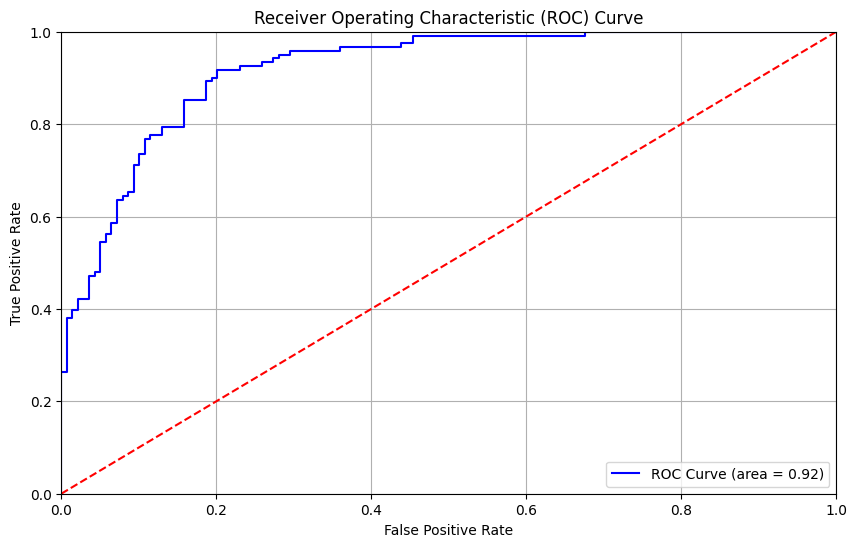

In [21]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

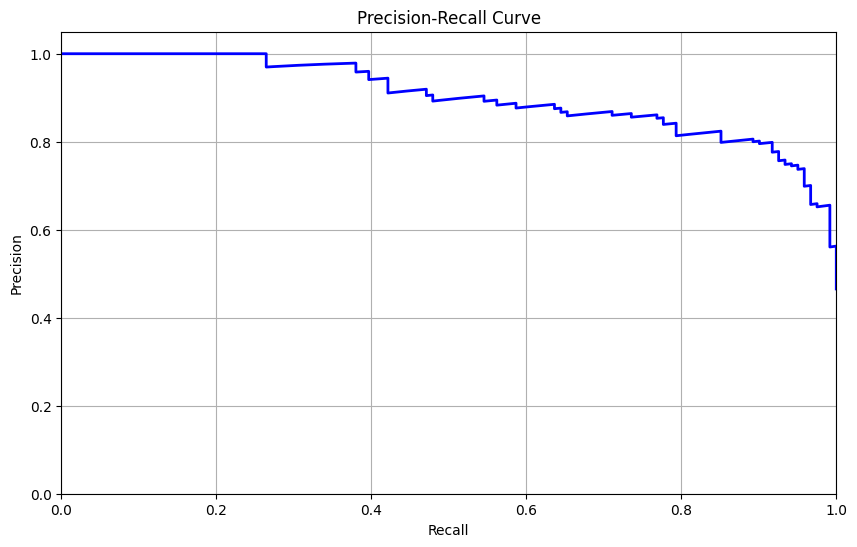

In [22]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()